In [1]:

! python -m pip install scikit-learn-intelex
from sklearnex import patch_sklearn
patch_sklearn()


import tweepy
import numpy as np
import pandas as pd
import os
import re
import time
import pickle
import random as rnd
import matplotlib.pyplot as plt
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import nltk
import matplotlib.patheffects as peffects

from sklearn.model_selection import StratifiedKFold
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import explained_variance_score, confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, auc, plot_roc_curve
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
import time as timelib
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
plt.style.use('fivethirtyeight')


[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bharg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bharg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bharg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bharg\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
file = '/content/drive/MyDrive/tweet_data.csv'

In [3]:
colnames = ['target', 'id', 'date','flag','user','text']

In [4]:
originalDataDF = pd.read_csv('data/tweet_data.csv', names=colnames, delimiter=',' ,engine='python', nrows=None, encoding='latin-1', header=None)

In [5]:
preprocesstime0 = timelib.time()

In [6]:
originalDataDF.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
def handling_emojis(text):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    text = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', text)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    text = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', text)
    # Love -- <3, :*
    text = re.sub(r'(<3|:\*)', ' EMO_POS ', text)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    text = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', text)
    # Sad -- :-(, : (, :(, ):, )-:
    text = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', text)
    # Cry -- :,(, :'(, :"(
    text = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', text)
    
    return text

In [8]:
# cleaning the text

# removing tagged username '@'
def cleaningText(text):
    text = text.strip('\'"?!,.():;') # removing punctuation
    text = re.sub(r'(.)\1+', r'\1\1', text) # convert more than 2 letter repetitions to 2 letter #fooood -> food
    text = re.sub(r'(-|\')','',text) # removing additional -& '
    text = re.sub(r'@[A-Za-z0-9]+','',text) #removing @usernames
    text = re.sub(r'#','',text) #removing '#' symbols
    text = re.sub(r'RT[\s]+','',text) #removes RT(Re-Tweet) string 
    text = re.sub(r'https?:\/\/\S+','',text) #removing the hyperlink
    text = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', '', text) #removing urls
    # Replace 2+ dots with space
    text = re.sub(r'\.{2,}', ' ', text)
    # Strip space, " and ' from tweet
    text = text.strip(' "\'')
    # Replace emojis with either EMO_POS or EMO_NEG
    text = handling_emojis(text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    text = text.lower() #make the text to lowercase
    return text


In [9]:
originalDataDF['text'] = originalDataDF['text'].apply(cleaningText)
originalDataDF['text'][0]

'aww, thats a bummer. you shoulda got david carr of third day to do it. emo_pos '

In [10]:
# making contracted words to normalized ones
contractionWords = {
"aren’t":"are not","can’t":"can not","couldn’t":"could not ","didn’t":"did not","doesn’t":"does not","don’t":"do not","hadn’t":"had not","hasn’t":"has not ","haven’t":"have not",
"I’m":"I am","I’ve":"I have","isn’t":"is not","let’s":"let us","mightn’t":"might not","mustn’t":"must not","shan’t":"shall not","shouldn’t":"should not","that’s":" that is","he’ll":" he will",
"I’ll":"I will","she’ll":"she will","she’s":"she is","there’s":"there is","they’ll":" they will","they’re":"they are","they’ve":"they have","we’re":"we are","we’ve":"we have","weren’t":"were not",
"what’ll":"what will","what’re":"what are","what’ve":"what have","where’s":"where is","who’d":"who would","who’ll":"who will","who’re":"who are","who’s":"who is","who’ve":"who have","won’t":"will not",
"wouldn’t":"would not","you’d":"you would","you’re":"you are","you’ve":"you have","it’s":"it is","wasn't":"was not"
}

In [11]:
# negation handling
def negationHandling(text):
    words = text.split()
    temp = [contractionWords[word] if word in contractionWords else word for word in words]
    temp = " ".join(temp)
    return temp
originalDataDF['text'] = originalDataDF['text'].apply(negationHandling)

In [12]:
#Tokenizing the words
word_set = []
def wordTokenize(text):
    tokens = word_tokenize(text)
    return tokens
originalDataDF['text'] = originalDataDF['text'].apply(wordTokenize)
originalDataDF['text'][0]

['aww',
 ',',
 'thats',
 'a',
 'bummer',
 '.',
 'you',
 'shoulda',
 'got',
 'david',
 'carr',
 'of',
 'third',
 'day',
 'to',
 'do',
 'it',
 '.',
 'emo_pos']

In [13]:
#Removing the stop words
stop_words = stopwords.words('english')
def removeStopWords(tokens):
    temp = [word for word in tokens if word not in stop_words]
    return temp
originalDataDF['text'] = originalDataDF['text'].apply(removeStopWords)
originalDataDF['text'][0]

['aww',
 ',',
 'thats',
 'bummer',
 '.',
 'shoulda',
 'got',
 'david',
 'carr',
 'third',
 'day',
 '.',
 'emo_pos']

In [14]:
#removing unwanted and not alpha characters
def removeUnnecessaryChars(tokens):
    temp = [word for word in tokens if word.isalpha()]
    return temp
originalDataDF['text'] = originalDataDF['text'].apply(removeUnnecessaryChars)
originalDataDF['text'][0]

['aww', 'thats', 'bummer', 'shoulda', 'got', 'david', 'carr', 'third', 'day']

In [15]:
#lemmatizing the words 
lemma = WordNetLemmatizer()
def lemmatizeTweets(wordList):
    temp = []
    for word in wordList:
        _word = lemma.lemmatize(word)
        temp.append(_word)
    return ' '.join(temp)
originalDataDF['text'] = originalDataDF['text'].apply(lemmatizeTweets)


In [16]:
#splitting the data into equal amounts of positive and negative words
def datasplitfortraining(l1=[],l2=[],m=0):
    k = 0
    for i in range(len(originalDataDF)):
        if(k==50000):
            break
        if originalDataDF['target'][i] == m:
            l1.append(originalDataDF['target'][i])
            l2.append(originalDataDF['text'][i])
            k+=1
    newmodifieddf = pd.DataFrame({'target':l1,'text':l2})
    return newmodifieddf



d1 = datasplitfortraining(m=4)
d2 = datasplitfortraining(m=2)
d3 = datasplitfortraining(m=0)

In [17]:
d3

,target,text
0,4,love u guy r best
1,4,im meeting one besties tonight cant wait girl ...
2,4,thanks twitter add sunisa got meet hin show dc...
3,4,sick really cheap hurt much eat real food plus...
4,4,effect everyone
...,...,...
99995,0,insomnia prob slept hr woke nd couldnt go back...
99996,0,mintues late meeting starting howd know going ...
99997,0,super excited tweeting event happening way fol...
99998,0,want another day much sht today got quot quot ...


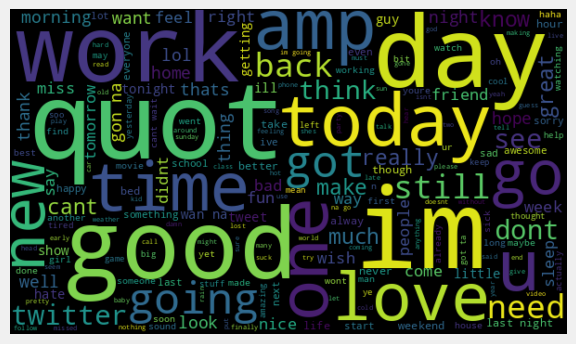

In [18]:
#plotting the word cloud
allwords = ''.join([t for t in d3['text']])
wordCloud = WordCloud(width=600,height=350,random_state=59,max_font_size=120).generate(allwords)

plt.imshow(wordCloud, interpolation= "bilinear")
plt.axis('off')
plt.show()

In [19]:
#creating tfidf vectorizer
vectorizer = TfidfVectorizer(min_df = 5,max_df=0.8,sublinear_tf = True,use_idf = True)

In [20]:
#training vectors
train_vectors = vectorizer.fit_transform(d3['text'])

In [21]:
#converting into required array format and labelling class
X = train_vectors.toarray()
y = np.where(d3['target'] == 0 , -1 , 1)

In [22]:
#Using train test split for 80 and 20 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=42)

In [23]:
preprocesstime1 = timelib.time()

In [24]:
preprocess_duration = preprocesstime1 - preprocesstime0
print("Elapsed Time: %.2f min" % (preprocess_duration / 60))

Elapsed Time: 5.02 min


In [25]:
X_train.shape

(80000, 9094)

In [26]:
y_train.shape

(80000,)

In [27]:
time0 = timelib.time()

In [28]:
'''
SVM from scratch with num of iterations and learning rate and lambad param
we initially asign random weights and bias
we map the y class values as 1 and -1
performing mathematical dot operation to satisfy the conditions
updating the weights with learning rate
making the differential weights and bias
finally predicting the values with dot of weight and bias
'''


class SVM:
    def __init__(self, no_of_iters=1000, learning_rate=1e-4, lambda_param=1e-2):
        self.no_of_iters = no_of_iters
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.weight = None
        self.bias = None

    def _initial_weights_bias(self, X):
        number_of_features = X.shape[1]
        self.weight = np.zeros(number_of_features)
        self.bias = 0

    def _class_map(self, y):
        return np.where(y == -1, -1, 1)

    def _satisfy_constraint(self, x, i):
        linear_model = np.dot(x, self.weight) + self.bias 
        
        return self.cls_map[i] * linear_model >= 1
    
    def _get_gradients(self, condition, x, i):
        if condition:
            diff_weight = self.lambda_param * self.weight
            diff_bias = 0
            return diff_weight, diff_bias
        
        diff_weight = self.lambda_param * self.weight - np.dot(self.cls_map[i], x)
        diff_bias = - self.cls_map[i]
        return diff_weight, diff_bias
    
    def _update_weights_bias(self, diff_weight, diff_bias):
        self.weight = self.weight - self.learning_rate * diff_weight
        self.bias = self.bias - self.learning_rate * diff_bias
    
    def fit(self, X, y):
        self._initial_weights_bias(X)
        self.cls_map = self._class_map(y)

        for _ in range(self.no_of_iters):
            for i, x in enumerate(X):
                condition = self._satisfy_constraint(x, i)
                diff_weight, diff_bias = self._get_gradients(condition, x, i)
                self._update_weights_bias(diff_weight, diff_bias)
    
    def predict(self, X):
        estimate = np.dot(X, self.weight) + self.bias
        prediction = np.sign(estimate)
        return np.where(prediction == -1, -1, 1)

In [29]:
#creating svm class object
svm_model = SVM()

In [30]:
#fitting the model
svm_model.fit(X_train, y_train)

In [31]:
time1 = timelib.time()
duration = time1 - time0
print("Elapsed Time: %.2f min" % (duration / 60))

Elapsed Time: 31.91 min


In [32]:
#predicting with test data
preds = svm_model.predict(X_test)

In [33]:
preds

array([ 1, -1, -1, ...,  1, -1, -1])

In [34]:
#creating the confusion matrix
cfm = confusion_matrix(y_test,preds)

In [35]:
cfm

array([[7842, 2158],
       [3615, 6385]], dtype=int64)

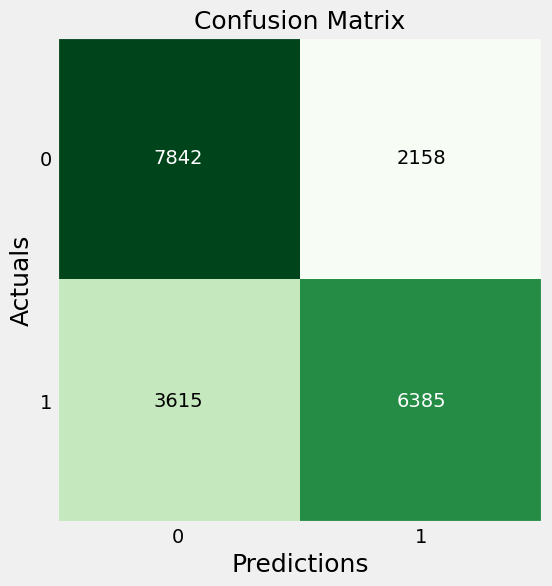

In [36]:
#Plotting the confusion matrix
from mlxtend.plotting import plot_confusion_matrix
 
fig, ax = plot_confusion_matrix(conf_mat=cfm, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [37]:
cfm.diagonal()/cfm.sum(axis=1)

array([0.7842, 0.6385])

In [38]:
#calculating all the required metrics
FalsePositive = cfm.sum(axis=0) - np.diag(cfm)  
FalseNegative = cfm.sum(axis=1) - np.diag(cfm)
TruePositive = np.diag(cfm)
TrueNegative = cfm.sum() - (FalsePositive + FalseNegative + TruePositive)

FalsePositive = FalsePositive.astype(float)
FalseNegative = FalseNegative.astype(float)
TruePositive = TruePositive.astype(float)
TrueNegative = TrueNegative.astype(float)

In [39]:
#  Recall, or True positive rate
TPR = TruePositive/(TruePositive+FalseNegative)
print('Recall :',TPR)
# Specificity or True negative rate
TNR = TrueNegative/(TrueNegative+FalsePositive) 
print('Specificity :',TNR)
# Precision or Positive predictive value
PPV = TruePositive/(TruePositive+FalsePositive)
print('Precision :',PPV)
# Negative Predictive value
NPV = TrueNegative/(TrueNegative+FalseNegative)
# Fall out or false positive rate
FPR = FalsePositive/(FalsePositive+TrueNegative)
# False negative rate
FNR = FalseNegative/(TruePositive+FalseNegative)
# False discovery rate
FDR = FalsePositive/(TruePositive+FalsePositive)

Recall : [0.7842 0.6385]
Specificity : [0.6385 0.7842]
Precision : [0.68447237 0.74739553]


In [40]:
# Finding accuracy
accuracy = (TruePositive+TrueNegative)/(TruePositive+FalsePositive+FalseNegative+TrueNegative)
accuracy[0]

0.71135

In [41]:
accuracy_score(y_test,preds)

0.71135

In [42]:
precision_score(y_test,preds)

0.7473955285028678

In [43]:
recall_score(y_test,preds)

0.6385

In [44]:
f1_score(y_test,preds)

0.6886695788168041

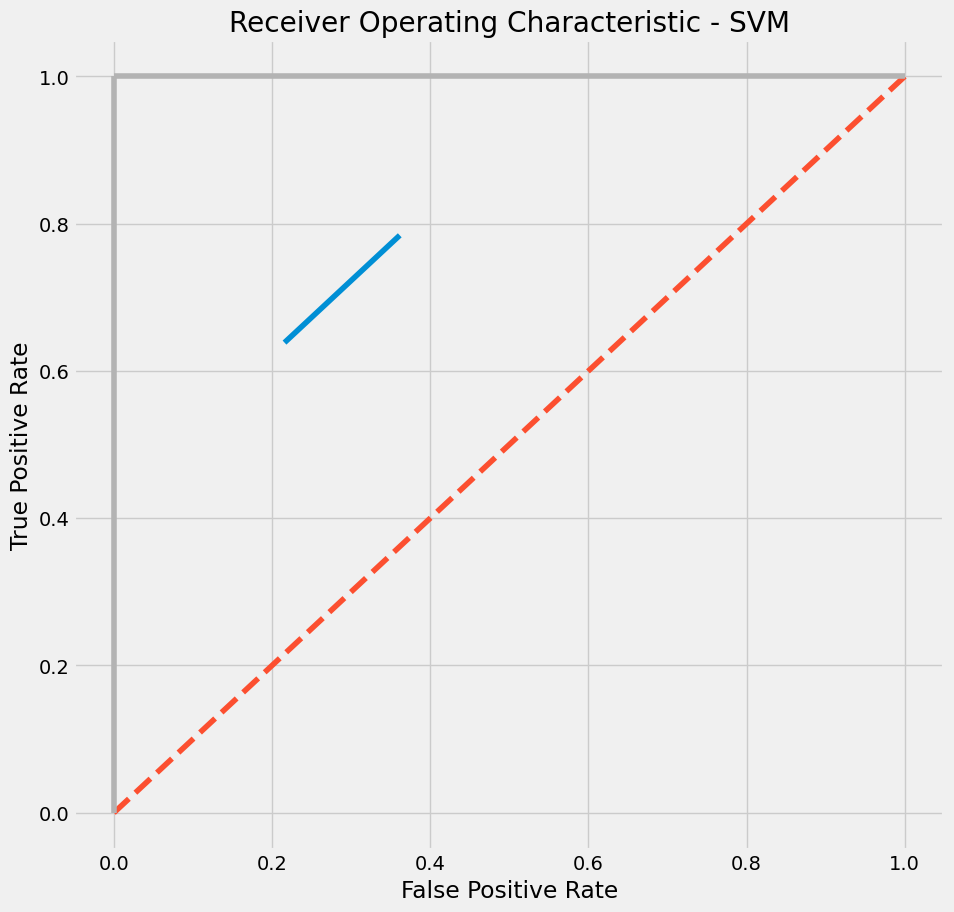

In [45]:
plt.subplots(figsize=(10,10))
plt.title('Receiver Operating Characteristic - SVM')
plt.plot(FPR, TPR)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [46]:
review = "SUPERB, I AM IN LOVE IN THIS PHONE"

In [47]:
review_vector = vectorizer.transform([review]) # vectorizing
print(svm_model.predict(review_vector.toarray()))

[1]


In [48]:
review = "Do not purchase this product.It is bad, my cell phone blast when I switched the charger on"

In [49]:
review_vector = vectorizer.transform([review]) # vectorizing
print(svm_model.predict(review_vector.toarray()))

[-1]


In [50]:
#creating k folds
strtfdKFold = StratifiedKFold(n_splits=3)

In [51]:
#splitting train 80 data into k folds
kfold = strtfdKFold.split(X_train, y_train)
scores = []


In [52]:
#performing kfold cross validation
for k, (train, test) in enumerate(kfold):
    svm_model.fit(X_train[train, :], y_train[train])
    preds = svm_model.predict(X_train[test, :])
    score = accuracy_score(y_train[test],preds)
    scores.append(score)
    print('Fold: %2d, Accuracy: %.3f' % (k+1, score))
    print('\n\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

Fold:  1, Accuracy: 0.684


Cross-Validation accuracy: 0.684 +/- 0.000
Fold:  2, Accuracy: 0.621


Cross-Validation accuracy: 0.652 +/- 0.031
Fold:  3, Accuracy: 0.717


Cross-Validation accuracy: 0.674 +/- 0.040


In [54]:
# pickling the vectorizer
pickle.dump(vectorizer, open('vectorizer.sav', 'wb'))
# pickling the model
pickle.dump(svm_model, open('svm_final_new_model.sav', 'wb'))